In [1]:
import jax
import jax.numpy as jnp
import gud
import matplotlib.pyplot as plt
import numpy as np
import optax
import diffrax
from flax import nnx

# for pretty visualization with jupyter notebooks
from IPython.display import clear_output

from utils import MNIST, UNet

# load fashion mnist as example data
dataset = MNIST(dataset='mnist')

rngs = nnx.Rngs(0)

In [2]:
stats = np.load('./datasets/fft_stats.npz')
mean = stats['mean']

In [3]:
# some convenience functions

def draw_data(space, dataset):
    x, _ = dataset.next()
    x = x.reshape(-1, 28*28, 1)
    x = x - mean[..., None]
    return space.wrap(data=x)


def plot_sample_trajectories(samples, width=8):
    cols, rows = samples.shape[:2]

    fig, axs = plt.subplots(rows, cols, figsize=(width, width / cols * rows))
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(samples[j, i].reshape(28, 28), cmap="gray", interpolation='none', vmin=-1, vmax=1)
            axs[i, j].axis('off')
    plt.tight_layout()
    return fig


# the function we pass to various constructions expects input and
# output to be wrapped in gud.Data

class EpsilonModel(nnx.Module):
    def __init__(self, base_model: nnx.Module, gaussian_default: bool = True):
        self.base_model = base_model
        self.gaussian_default = gaussian_default

    def __call__(self, nv, x):
        # here convert back and forth so network input & output are in original space
        eps = self.base_model(nv.t, x.data)
        eps = x.space.wrap(data=eps)

        if self.gaussian_default:
            eps = eps.space.wrap(comp_white=eps.comp_white + x.comp_white)

        return eps

# Training

First, we need ot set up schedule and space to use.


In [4]:
explained_variance = stats['var_fft']
labels = -np.log(explained_variance)

schedule = gud.soft_conditioning_schedule(
    labels=labels,
    gamma_min_target=-7,
    gamma_max_target=7,
    softness=1,
)

space = gud.FourierSpace((28, 28), scale=jnp.sqrt(explained_variance))

In [5]:
x, _ = dataset.next()
# if we are using variance, we must be sure that we subtract the mean
# otherwise, some means may be larger than their variance, making the latter
# a bad measure for estimating "true" SNR
x = x - mean[..., None]
data = space.wrap(data=x)

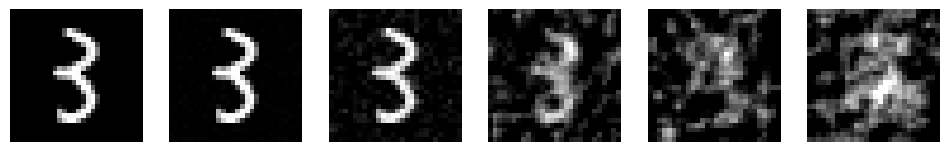

In [6]:
plt.figure(figsize=(12, 3))

for i, t in enumerate(np.linspace(0, 1, 6)):
    plt.subplot(1, 6, i + 1)
    ns = schedule(t, shape=data.shape)

    noised, z = gud.ou_process(rngs(), data, ns)

    # add mean back in
    noised_x = noised.data[0] + stats['mean'][..., None]

    plt.imshow(noised_x.reshape(28, 28), cmap="gray", vmin=-1, vmax=1)
    plt.axis('off')
plt.show()


## Model

In [7]:
model = EpsilonModel(
    UNet(
        (28, 28),
        rngs=nnx.Rngs(0),
        base_channels=16,
        channel_multipliers=(1, 2, 4),
        attention_heads=2,
    )
)

In [8]:
model = EpsilonModel(
    # rather small network, just for testing
    UNet(
        (28, 28),
        rngs=nnx.Rngs(0),
        base_channels=8,
        channel_multipliers=(1, 2),
        attention_heads=None,
    )
)

## Training logic

In [9]:
# for the loss function, we use epsilon metching

def loss_fn(model, x, rng):
    rng_t, rng_noise = jax.random.split(rng)

    # random time for each sample in batch & noise
    t = jnp.linspace(0, 1, len(x), endpoint=False)
    t = t + jax.random.uniform(rng_t, shape=t.shape, minval=0.0, maxval=1/len(x))

    ns = schedule(t, shape=x.shape)
    x_noised, z = gud.ou_process(rng_noise, x, ns)

    eps = model(ns, x_noised)

    return jnp.mean(jnp.abs(eps.comp_white - z.comp_white)**2)


# set up optimizer
optimizer = nnx.Optimizer(
    model=model,
    tx=optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=3e-4),
    ),
    wrt=nnx.Param,
)

# combine into single compiled update step
@nnx.jit
def update_step(optimizer, model, x, rngs):
    loss, grads = nnx.value_and_grad(loss_fn, argnums=nnx.DiffState(0, nnx.Param))(model, x, rngs())
    optimizer.update(grads=grads, model=model)
    return loss


# for visualization during training
rng_sample = jax.random.key(42)
@nnx.jit
def generate_samples(model, schedule, space, dt=0.001, rng=rng_sample):
    samples = gud.sample_reverse_sde(
        rng,
        3,
        model,
        schedule,
        space,
        (28 * 28, 1),
        dt=dt,
        saveat=diffrax.SaveAt(ts=np.linspace(1.0, 0.0, 8)),
    )
    return samples + mean[..., None]

## Training loop

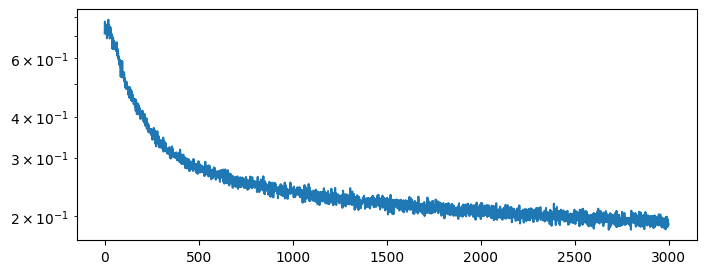

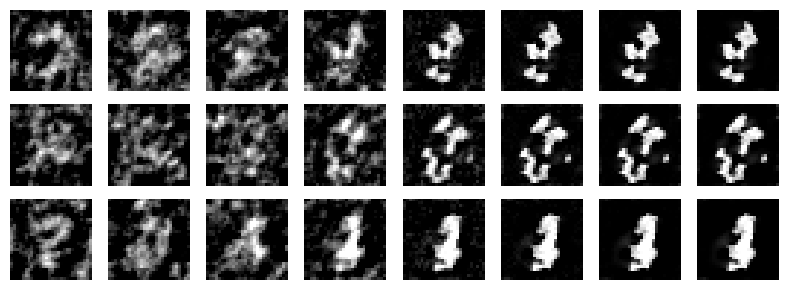

In [10]:
log_every = 100
train_steps = 3000

model.train()
losses = np.full(train_steps, np.nan)
for i in range(train_steps):
    losses[i] = update_step(optimizer, model, draw_data(space, dataset), rngs)
    if (i + 1) % log_every == 0:
        model.eval()
        eval_samples = generate_samples(model, schedule, space)
        model.train()

        clear_output(wait=True)

        plt.figure(figsize=(8, 3))
        plt.semilogy(losses)
        plt.show()

        plot_sample_trajectories(eval_samples)
        plt.show()